In [1]:
from data_processing import *

from scoring_lstm import Model

from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib

from scipy.stats import mode
import pandas as pd
import numpy as np
import warnings
import joblib
import torch
import ast

league_model_col_order = ['forward', 'gp', 'draft_pick', 'is_drafted', 'height', 'weight', 'real_season_age',
                        'gpg', 'apg', 'ppg', 'perc_team_g', 'perc_team_a', 'perc_team_tp', 'AJHL', 
                        'Allsvenskan', 'BCHL', 'CCHL', 'Czech', 'Czech2', 'Jr. A SM-liiga', 'KHL', 'Liiga',
                        'MHL', 'NCAA', 'NHL', 'NLA', 'OHL', 'OJHL', 'QMJHL', 'SHL', 'SJHL', 'SuperElit', 
                        'USHL', 'VHL', 'WHL', 18, 19, 20, 21, 22, 23, 'round_1.0', 
                        'round_2.0', 'round_3.0', 'round_4.0', 'round_5.0', 
                        'round_6.0', 'round_7.0', 'round_8.0', 'round_9.0']

scoring_model_col_order =['forward', 'gp', 'gp_y_plus_1', 'draft_pick', 'is_drafted',
                          'height', 'weight', 'real_season_age', 'gpg', 'apg', 'ppg', 'perc_team_g', 
                          'perc_team_a', 'perc_team_tp', 'AJHL', 'Allsvenskan', 'BCHL', 'CCHL', 'Czech',
                          'Czech2', 'Jr. A SM-liiga', 'KHL', 'Liiga', 'MHL', 'NCAA', 'NHL', 'NLA',
                          'OHL', 'OJHL', 'QMJHL', 'SHL', 'SJHL', 'SuperElit', 'USHL', 'VHL', 'WHL', 
                          18, 19, 20, 21, 22, 23, 'round_1.0', 'round_2.0',
                          'round_3.0', 'round_4.0', 'round_5.0', 'round_6.0', 'round_7.0',
                          'round_8.0', 'round_9.0', 'next_yr_AJHL', 'next_yr_Allsvenskan', 
                          'next_yr_BCHL', 'next_yr_CCHL', 'next_yr_Czech', 'next_yr_Czech2', 
                          'next_yr_Jr. A SM-liiga', 'next_yr_KHL', 'next_yr_Liiga', 
                          'next_yr_MHL', 'next_yr_NCAA', 'next_yr_NHL', 'next_yr_NLA',
                          'next_yr_OHL', 'next_yr_OJHL', 'next_yr_QMJHL', 
                          'next_yr_SHL', 'next_yr_SJHL', 'next_yr_SuperElit', 
                          'next_yr_USHL', 'next_yr_VHL', 'next_yr_WHL']

pd.set_option('max_column', 0)
warnings.filterwarnings('ignore')

class GeneratePlayer(object):
    def __init__(self):
        self.dataset = pd.read_csv('../data/player_season_stats.csv')
        
        self.league_model = joblib.load('../models/predict_next_league.pkl')
        self.scoring_model = joblib.load('../models/scoring_model.pkl')
        self.scoring_lstm = Model() 
        self.scoring_lstm.load_state_dict(torch.load('../models/scoring_lstm_checkpoint.pth'))
        self.scoring_lstm.eval()
        
        self.ppg_model = joblib.load('../models/ppg_team_model.pkl')
        self.gpg_model = joblib.load('../models/gpg_team_model.pkl')
        self.apg_model = joblib.load('../models/apg_team_model.pkl')
        
    def initialize_player(self, playerid):
        self.playerid = playerid
        self.player_df = self.dataset[self.dataset.playerid == int(playerid)]
        # for current draft eligibles, impute their average draft position
        self.player_df = draft_current_year(self.player_df)
        self.player_name = self.player_df.player.iloc[0]
        self.current_age = self.player_df.season_age.max()
        self.start_age = self.player_df.season_age.max()
        self.start_league = self.player_df[self.player_df.season_age == self.player_df.season_age.max()].league.iloc[0]
        self.a_proportion = (self.player_df.apg / self.player_df.ppg).median()
        self.g_proportion = 1 - self.a_proportion
        self.projections = pd.DataFrame()
        self.position = self.get_position()
        self.scoring_by_position()
    
    def scoring_by_position(self):
    
        data = player.dataset

        data['primary_position'] = data.position.apply(get_primary_position)

        self.position_ppg = data[(data.season_age >= 17)
                                 & (data.season_age <= 23)].groupby('primary_position').ppg.mean().to_dict()


    def impute_games_played(self):
        
        team_mask = self.dataset.team.apply(lambda x : len(ast.literal_eval(x)) > 1)

        self.gp_dict = self.dataset[(self.dataset.gp < 85)
                               & (self.dataset.season_age >= 17)
                               & ~(team_mask)
                               & (self.dataset.season_age <= 23)].groupby('league').gp.mean().round().to_dict()
        
        self.gp_full = self.dataset[(self.dataset.gp < 85)
                               & (self.dataset.season_age >= 17)
                               & ~(team_mask)
                               & (self.dataset.season_age <= 23)].groupby('league').gp.apply(lambda x: mode(x)[0][0]).round().to_dict()
        
    def get_position(self):
        
        return get_primary_position(self.player_df.position.iloc[0])
        
    def load_features(self, target):
        
        self.features, self.target, self.scaler = prepare_features(self.dataset, target)
        
    def get_player_index(self):
    
        return (self.player_df.playerid.iloc[0], self.player_df.player.iloc[0])
    
    def get_league_index(self):
        
        self.league_index = { i:k for i, k in enumerate(np.unique(self.dataset['league']))}
    
    def generate_league_season(self, player_df):
        
        # load entire model feature set
        self.load_features('league_y_plus_1')
        # instantiate league index
        self.get_league_index()
        # league to game played mapping
        self.impute_games_played()
        # Pad player career to get entries for all possible seasons
        self.pad_player = pad_data(player_df, [self.get_player_index()])
        # Get age of the last played season
        self.current_age = self.pad_player.season_age.max()
        # create retrieve data from season and produce model features
        self.current_season = self.pad_player[self.pad_player.season_age == self.current_age]
        self.current_league = self.current_season.league.iloc[0]
        self.current_season = prepare_features_single_season(self.current_season, self.scaler, 'league_y_plus_1')
        # append model features to entire dataset to inherent all the necessary columns
        player_league_features = pd.DataFrame(self.features.loc[self.get_player_index()].append(
            self.current_season.droplevel([0,1])).loc[self.current_age])
        # predict next year league probabilities for the last played season
        league_pred = self.league_model.predict_proba(
            player_league_features.T.fillna(0)[league_model_col_order]).round(3)
        # write league probabilities to player dataframe to iterate over
        league_probs = pd.DataFrame([[self.current_league,
                                      self.league_index[idx], 
                                      np.squeeze(league_pred)[idx]] for idx in np.flatnonzero(league_pred > 0)],
                                    columns=['start_league', 'league', 'probability'],
                                    index=pd.MultiIndex.from_tuples(
                                        [self.get_player_index() + (self.current_age + 1,)\
                                         for i in range(len(np.flatnonzero(league_pred > 0)))],
                                        names=['playerid', 'player', 'season_age'])
                                   )# incriment year
        
        # sort by probability
        league_probs.sort_values('probability', ascending=False, inplace=True)
        # only return values that > 2% probability
        league_probs = league_probs[(league_probs.probability >= 0.1) |
                                              (league_probs.league == 'NHL')].reset_index().head(3)
        # redistribute probabilities 
        league_probs.probability /= league_probs.probability.sum()
    
        league_probs['gp'] = league_probs.league.map(self.gp_dict)

        self.league_probs = league_probs
        
    def generate_league_scoring(self, player_df):
        # load entire model feature set
        self.load_features('ppg_y_plus_1')

        for i, (_, sim) in enumerate(self.league_probs.iterrows()):
            # create retrieve data from season and produce model features
            self.current_season = self.pad_player[self.pad_player.season_age == self.current_age]
            self.current_season['gp_y_plus_1'] = sim['gp']
            self.current_season = prepare_features_single_season(self.current_season, 
                                                                       self.scaler, 
                                                                       'ppg_y_plus_1')
            self.current_season['next_yr_{}'.format(sim['league'])] = 1
            # player features for lstm
            player_league_features = pd.DataFrame(
                self.features.loc[self.get_player_index()]\
                                        .append(self.current_season.droplevel([0,1]))
            ).fillna(0)[scoring_model_col_order]

            # pad sequence for LSTM
            player_league_features = pad_sequence(player_league_features).values

            with torch.no_grad():
                lstm_preds = torch.Tensor([])  # to store our predictions for season t+1
                pred_t, _ = self.scoring_lstm(player_league_features,
                                                 np.ndarray((player_league_features.shape[0], 1))) # dummy target array
                lstm_preds = torch.cat((lstm_preds, pred_t))

            self.league_probs.ix[i, 'ppg'] = lstm_preds.detach().numpy()[-1]
        
        # partition ppg into assists and goals
        self.league_probs['gpg'] = self.league_probs.ppg * self.g_proportion
        self.league_probs['apg'] = self.league_probs.ppg * self.a_proportion
        # Append predictions to projections dataframe
#         self.projections = self.projections.append(self.league_probs.reset_index())
            
    def generate_league_scoring_baseline(self):

        # load entire model feature set
        self.load_features('ppg_y_plus_1')
        # instantiate league index
        self.get_league_index()
        # league to game played mapping
        self.impute_games_played()
        
        # Pad player career to get entries for all possible seasons
        pad_player = pad_data(self.player_df, [self.get_player_index()])
        self.current_age = pad_player.season_age.max()

        for i, (_, sim) in enumerate(self.league_probs.iterrows()):
            # create retrieve data from season and produce model features
            self.current_season = pad_player[pad_player.season_age == self.current_age]
            self.current_season['gp_y_plus_1'] = sim['gp_y_plus_1']
            self.current_season = prepare_features_single_season(self.current_season, self.scaler, 'ppg_y_plus_1')
            self.current_season['next_yr_{}'.format(sim['league'])] = 1
            # append model features to entire dataset to inherent all the necessary columns
            player_league_features = pd.DataFrame(self.features.loc[self.get_player_index()].append(
                self.current_season.droplevel([0,1])).loc[self.current_age])

            scoring_pred = self.scoring_model.predict(
                        player_league_features.T.fillna(0)[scoring_model_col_order]).round(3)

            self.league_probs.ix[i, 'ppg'] = scoring_pred
    
    def interpolate_team_scoring(self):

        features = self.league_probs[['ppg', 'apg', 'gpg']].merge(
            pd.get_dummies(self.league_probs.reset_index()['league']),
            left_index=True,
            right_index=True).merge(
            pd.get_dummies(self.league_probs.reset_index()['season_age'].astype(int)),
            left_index=True,
            right_index=True)

        features.index = np.full((features.shape[0],), self.current_age + 1)

        X = self.features.loc[self.get_player_index()]
        for _, row in features.iterrows():
            X = X.append(row.to_frame().T)
            
        X = X.loc[(self.current_age + 1)]

        league_feats = [v for k,v in self.league_index.items()][1:]
        age_feats = [i for i in range(18, 24)]
        
        input_dim = X.shape[0] if X.shape[0] != self.features.shape[1] else 1
        
        self.league_probs['perc_team_a'] = self.apg_model.predict(
            X.fillna(0)[['apg'] + league_feats + age_feats].values.reshape(input_dim, self.apg_model.coef_.shape[0]))
        self.league_probs['perc_team_g'] = self.gpg_model.predict(
            X.fillna(0)[['gpg'] + league_feats + age_feats].values.reshape(input_dim, self.apg_model.coef_.shape[0]))
        self.league_probs['perc_team_tp'] = self.ppg_model.predict(
            X.fillna(0)[['ppg'] + league_feats + age_feats].values.reshape(input_dim, self.ppg_model.coef_.shape[0]))
    
    def recursive_season_concat(self, season, df = pd.DataFrame()):
        
        prev_season = self.projections[self.projections.node == season['start_node']]
        
        if prev_season.empty:
            
            return df.append(season.to_frame().T)

        else:
            df = df.append(season)
#             season = df.loc[df.season_age == df.season_age.min()].squeeze()

            return self.recursive_season_concat(prev_season.squeeze(), df).sort_values('season_age')

    def fill_player_attributes(self, season):
        
        df = self.player_df.append(self.recursive_season_concat(season))
        df['position'] = df['position'].fillna(method = 'ffill') 
        df['height'] = df['height'].fillna(method = 'ffill')
        df['weight'] = df['weight'].fillna(method = 'ffill')
        df['draft_year_eligible'] = df['draft_year_eligible'] .fillna(method = 'ffill') 
        df['draft_year'] = df['draft_year'] .fillna(method = 'ffill') 
        df['draft_round'] = df['draft_round'].fillna(method = 'ffill')
        df['draft_pick'] = df['draft_pick'].fillna(method = 'ffill')
        df['real_season_age'] = (df['real_season_age'].min() + np.arange(0, len(df)))
        df['start_year'] = (df['start_year'].min() + np.arange(0, len(df)))
        df['end_year'] = (df['end_year'].min() + np.arange(0, len(df)))

        return df
            
    def simulate_player_development(self, node_counter=1): 
    
        while self.current_age + 1 <= 23:

            print(f'--- Simulating Seasons --- {self.player_name} --- Age: {int(self.current_age)}')

            if node_counter == 1:
                self.generate_league_season(self.player_df)
                self.generate_league_scoring(self.player_df)
                self.interpolate_team_scoring()
                self.league_probs['start_node'] = node_counter
                self.league_probs['node'] = np.arange(node_counter + 1, node_counter + 1 + len(self.league_probs))

                self.current_simulation = self.league_probs
                self.projections = self.projections.append(self.current_simulation)
                node_counter += len(self.league_probs)
                self.current_age += 1
                print(f'--- Simulation Complete --- {self.player_name} --- Age: {int(self.current_age)}')

            else:
                print(f'--- Simulating Seasons --- {self.player_name} --- Age: {int(self.current_age)}')
                simulated_seasons = pd.DataFrame()

                for _, sim in self.current_simulation.iterrows():
                    player_df = self.fill_player_attributes(sim)
                    self.generate_league_season(player_df)
                    self.generate_league_scoring(player_df)
                    self.interpolate_team_scoring()
                    self.league_probs['start_node'] = sim['node']
                    self.league_probs['node'] = np.arange(node_counter + 1, node_counter + 1 + len(self.league_probs))
                    # Append predictions to projections dataframe
                    simulated_seasons = simulated_seasons.append(self.league_probs)
                    self.projections = self.projections.append(self.league_probs)
                    node_counter += len(self.league_probs)

                self.current_simulation = simulated_seasons
                print(f'--- Simulation Complete --- {self.player_name} --- Age: {int(self.current_age)}')
                self.current_age += 1

            self.simulate_player_development(node_counter)
        
        # to calculate epoints let players play full seasons
        self.projections['gp'] = self.projections.league.map(self.gp_full)
        self.projections['epoints'] = self.projections.ppg * self.projections.gp
        
    def generate_network_graph(self):
        
        self.G = nx.convert_matrix.from_pandas_edgelist(self.projections.round(3),
                             source='start_node',
                             target='node',
                             edge_attr=['probability', 'epoints'],
                             create_using=nx.DiGraph())
        
        self.G.nodes[1]['league'] = self.start_league
        self.G.nodes[1]['age'] = self.start_age
        self.G.nodes[1]['epoints'] = self.player_df[self.player_df.season_age == self.player_df.season_age.max()].tp.values.item()
        self.G.nodes[1]['ppg'] = self.player_df[self.player_df.season_age == self.player_df.season_age.max()].round(3).ppg.values.item()
        self.G.nodes[1]['cond_prob'] = node_probability(self.G, 1)
        self.G.nodes[1]['xvalue'] = round(node_expected_value(self.G, 1),3)
        
        for n in self.projections.node.values:
            self.G.nodes[n]['league'] = self.projections[self.projections.node == n].league.values.item()
            self.G.nodes[n]['age'] = self.projections[self.projections.node == n].season_age.values.item()
            self.G.nodes[n]['epoints'] = self.projections[self.projections.node == n].epoints.values.item()
            self.G.nodes[n]['ppg'] = self.projections[self.projections.node == n].ppg.round(3).values.item()
            self.G.nodes[n]['cond_prob'] = node_probability(self.G, n)
            self.G.nodes[n]['xvalue'] = round(node_expected_value(self.G, n),3)
        
        self.calculate_value_metrics()
        
    def plot_network_graph(self):
        
        matplotlib.rc('font',family='monospace')

        fig, ax = plt.subplots(figsize=(20,10))

        # create tree layout and rescale based on age
        pos = graphviz_layout(self.G, prog='dot')
        # array of ages for y-axis
        ages = np.arange(self.start_age,
                         self.projections.season_age.astype(int).max() + 1,
                         1)
        # rescale x,y coordinates
        y = np.array([xy[1] for _, xy in pos.items()])
        y_rescale = (y.max() / y.min()) / (ages.max() / ages.min())
        y_map = { k:v for k,v in zip(sorted(np.unique(y))[::-1], ages)}
        pos = {u :(v[0] / y_rescale, y_map[v[1]]) for u,v in pos.items()}

        # set params
#         node_sizes = [int(self.G.nodes[1]['ppg'] / self.position_ppg[self.position] * 300)] \
#         + [int(v * 300) for v in self.projections.ppg.div(self.position_ppg[self.position]).values.tolist()]
        node_sizes = [self.G.nodes[g]['ppg'] / self.position_ppg[self.position] * 500 for g in self.G.nodes]
        self.node_sizes = node_sizes

        # draw nodes
        nodes = nx.draw_networkx_nodes(self.G,
                                       pos,
                                       node_size=node_sizes,
                                       node_color='dodgerblue',
                                       ax=ax)
        node_labels = nx.get_node_attributes(self.G, 'league')
        nx.draw_networkx_labels(self.G,
                                pos,
                                node_labels,
                                font_size=14,
                                ax=ax, 
                                font_family='monospace', 
                                font_color='black', 
                                font_weight='bold',
                                font_stretch = 'semi-expanded')

        # draw edges
        edges = nx.draw_networkx_edges(self.G,
                                       pos, 
                                       arrowstyle='->', 
                                       arrowsize=20, 
                                       edge_cmap=plt.cm.Greys, 
                                       width=3,
                                       ax=ax)
        edge_labels = nx.get_edge_attributes(self.G, 'probability')
        nx.draw_networkx_edge_labels(self.G, 
                                     pos, 
                                     edge_labels, 
                                     font_size=12,
                                     ax=ax, 
                                     font_family='monospace')

        # set alpha value for each edge
        for i in range(len(self.projections)):
            edges[i].set_alpha(self.projections.probability.values[i])

        # colourscale for colourbar
        pc = matplotlib.collections.PatchCollection(edges, cmap=plt.cm.Greys)
        pc.set_array([(5 + i) / (30 + 4) for i in range(30)])
        plt.colorbar(pc).ax.set_title('Transition %')
        # create legend for projected points
        custom_leg = [mlines.Line2D([0], [0], marker='o', color='dodgerblue', linestyle='None') for _ in range(0,5)]
        # 4 part distirubtion
        Q1 = np.percentile([self.G.nodes[g]['ppg'] for g in self.G.nodes], 25, interpolation = 'midpoint').round(1) 
        Q2 = np.percentile([self.G.nodes[g]['ppg'] for g in self.G.nodes], 50, interpolation = 'midpoint').round(1) 
        Q3 = np.percentile([self.G.nodes[g]['ppg'] for g in self.G.nodes], 75, interpolation = 'midpoint').round(1)
        Q4 = np.percentile([self.G.nodes[g]['ppg'] for g in self.G.nodes], 100, interpolation = 'midpoint').round(1)
        point_range=[Q1, Q2, Q3, Q4]
        self.point_range = point_range
        custom_leg = [mlines.Line2D([0], [0],
                                    marker='o',
                                    color='dodgerblue',
                                    markersize=point_range[i] / self.position_ppg[self.position] * 10 ,
                                    linestyle='None') for i in range(0,4)]
        leg = plt.legend(custom_leg, point_range,
                         title = 'Projected Points (PPG)',
                         labelspacing=2.5,
                         handletextpad=1.5,
                         borderpad=1.5,
                         ncol=4,)
            
        ax.annotate('', xytext=(-.075, 0),  xy=(-.075, 1),  xycoords='axes fraction', arrowprops=dict(color='black', width=2))

        # axis changes
        ax.set_yticks(ages)
        ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)
        ax.set_ylabel('Season Age', size=16, weight='bold')
        ax.set_xlabel('MeaningleX Axis', size=12)
        plt.gca().yaxis.grid(True, linestyle='--',)
        plt.title(f"{self.player_name} Player Development", fontsize=18, fontweight='bold')
        footnote = """By: Connor Jung @ConnorJungle, Data Source: Elite Prospects"""
        plt.figtext(0.125, 0.05, footnote)
        # save image
        fname = '_'.join(self.player_name.split()).lower()
        plt.savefig(f"../images/{fname}_{self.playerid}_player_development_network_graph.png",
                    dpi=300,
                    bbox_inches='tight',
                    pad_inches=1.2,
                    format='png')
        
        plt.show()
        
    def get_nhl_value(self):

        nodes = self.projections[(self.projections.start_node==1)].node

        return dict(nhl_expected_value=round(sum([nhl_expected_value(self.G, n) for n in nodes]),2))

    def get_nhl_path(self):

        nodes = self.projections[(self.projections.season_age==23)
                                  & (self.projections.league=='NHL')].node

        probs = []
        max_prob = 0
        max_node = 1

        for node in nodes:
            node_prob = node_probability(self.G, node)
            if node_prob > max_prob:
                max_prob = node_prob
                max_node = node
            probs.append(node_prob)

        return dict(nhl_likelihood=round(sum(probs),2), most_likelihood_nhl_node=max_node)
        
    def calculate_value_metrics(self):
            
        player_value = dict(playerid = self.playerid,
                            player_name = self.player_name,
                            position = self.position)

        player_value.update(self.get_nhl_path())

        player_value.update(self.get_nhl_value())

        self.player_value = player_value
            
    def run(self, playerid):
    
        self.initialize_player(playerid)
        self.simulate_player_development()
        self.generate_network_graph()
        self.plot_network_graph()

        return self.projections
        
def node_probability(G, node):
    
    probabilities = []
    for n in sorted(nx.ancestors(G, node))[::-1]:
        probabilities.append(G.edges[(n, node)]['probability'])
        node=n
    return np.prod(probabilities)

def node_expected_value(G, node):

    return sum(G.nodes[node]['epoints'] * G.nodes[node]['cond_prob'] for n in nx.ancestors(G, node) | {node})

def nhl_expected_value(G, node):
        
    return np.sum([G.nodes[node]['epoints'] * G.nodes[node]['cond_prob'] if G.nodes[node]['league'] == 'NHL' else 0] + \
                [G.nodes[n]['epoints'] * G.nodes[n]['cond_prob']\
                   for n in nx.descendants(G, node) if G.nodes[n]['league'] == 'NHL']).round(1)


In [2]:
player = GeneratePlayer()

[10:20:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [11]:
player.initialize_player('201940')
player.simulate_player_development(node_counter=1)
player.generate_network_graph()

--- Simulating Seasons --- Cole Perfetti --- Age: 18
--- Simulation Complete --- Cole Perfetti --- Age: 19
--- Simulating Seasons --- Cole Perfetti --- Age: 19
--- Simulating Seasons --- Cole Perfetti --- Age: 19
--- Simulation Complete --- Cole Perfetti --- Age: 19
--- Simulating Seasons --- Cole Perfetti --- Age: 20
--- Simulating Seasons --- Cole Perfetti --- Age: 20
--- Simulation Complete --- Cole Perfetti --- Age: 20
--- Simulating Seasons --- Cole Perfetti --- Age: 21
--- Simulating Seasons --- Cole Perfetti --- Age: 21
--- Simulation Complete --- Cole Perfetti --- Age: 21
--- Simulating Seasons --- Cole Perfetti --- Age: 22
--- Simulating Seasons --- Cole Perfetti --- Age: 22
--- Simulation Complete --- Cole Perfetti --- Age: 22


In [16]:
player.projections[player.projections.league == 'NHL']

,playerid,player,season_age,start_league,league,probability,gp,ppg,gpg,apg,perc_team_a,perc_team_g,perc_team_tp,start_node,node,epoints
1,201940,Cole Perfetti,19.0,OHL,NHL,0.330425,82.0,0.902318,0.375966,0.526352,0.100089,0.121141,0.106998,1,3,73.990042
1,201940,Cole Perfetti,20.0,OHL,NHL,0.331533,82.0,1.180026,0.491678,0.688349,0.128196,0.154548,0.136893,2,5,96.762156
0,201940,Cole Perfetti,20.0,NHL,NHL,1.000000,82.0,1.233689,0.514037,0.719652,0.133613,0.161118,0.142665,3,6,101.162494
0,201940,Cole Perfetti,21.0,OHL,NHL,0.810036,82.0,1.076566,0.448569,0.627997,0.118603,0.142067,0.126469,4,7,88.278410
0,201940,Cole Perfetti,21.0,NHL,NHL,1.000000,82.0,1.286433,0.536014,0.750419,0.139787,0.167760,0.149042,5,9,105.487485
0,201940,Cole Perfetti,21.0,NHL,NHL,1.000000,82.0,1.311249,0.546354,0.764896,0.142292,0.170799,0.151711,6,10,107.522459
0,201940,Cole Perfetti,22.0,NHL,NHL,1.000000,82.0,1.376413,0.573505,0.802908,0.150023,0.180167,0.159954,7,11,112.865875
0,201940,Cole Perfetti,22.0,OHL,NHL,1.000000,82.0,1.117809,0.465754,0.652055,0.123919,0.148507,0.132140,8,12,91.660343
0,201940,Cole Perfetti,22.0,NHL,NHL,1.000000,82.0,1.520847,0.633686,0.887161,0.164602,0.197850,0.175489,9,13,124.709441
0,201940,Cole Perfetti,22.0,NHL,NHL,1.000000,82.0,1.537181,0.640492,0.896689,0.166251,0.199850,0.177246,10,14,126.048853


In [13]:
pd.DataFrame([player.player_value])

,playerid,player_name,position,nhl_likelihood,most_likelihood_nhl_node,nhl_expected_value
0,201940,Cole Perfetti,F,1.0,15,402.3


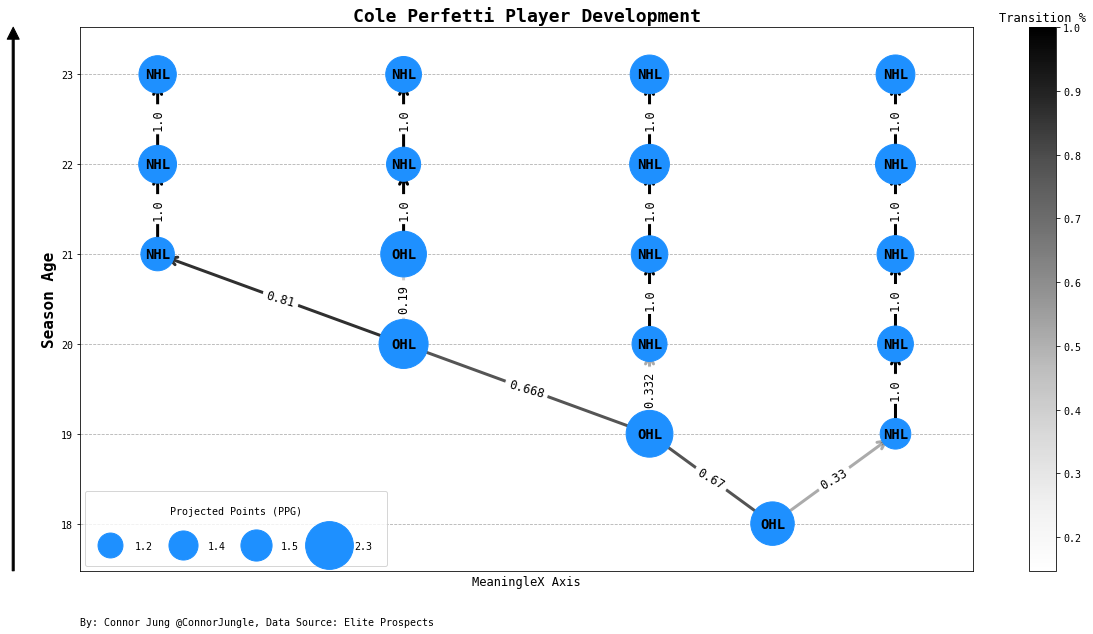

In [14]:
player.plot_network_graph()

### NHL path maximization

In [82]:
def get_nhl_path(self):

    nodes = self.projections[(self.projections.season_age==23)
                              & (self.projections.league=='NHL')].node

    probs = []
    max_prob = 0
    max_node = 1
    
    for node in nodes:
        node_prob = node_probability(self.G, node)
        if node_prob > max_prob:
            max_prob = node_prob
            max_node = node
        probs.append(node_prob)
        
    return dict(nhl_likelihood=round(sum(probs),2), most_likelihood_nhl_node=max_node)

def nhl_expected_value(G, node):
        
    return np.sum([G.nodes[n]['epoints'] * G.nodes[n]['cond_prob']\
                   for n in nx.descendants(G, node) if G.nodes[n]['league'] == 'NHL']).round(1)

def get_nhl_value(self):

    nodes = self.projections[(self.projections.start_node==1)].node
        
    return dict(nhl_expected_value=round(sum([nhl_expected_value(self.G, n) for n in nodes]),2))

In [98]:
player_value = dict(playerid = player.playerid,
                    player_name = player.player_name)

player_value.update(get_nhl_path(player))

player_value.update(get_nhl_value(player))

self.player_value = player_value

In [ ]:
player.get

# Debugging

In [73]:
player.projections[player.projections.league == 'NHL']

,playerid,player,season_age,start_league,league,probability,gp,ppg,gpg,apg,perc_team_a,perc_team_g,perc_team_tp,start_node,node,epoints,nhl_xvalue,xvalue,cond_probability
1,496724,Bobby Brink,20.0,NCAA,NHL,0.098301,82.0,0.540381,0.270190,0.270190,0.055838,0.089469,0.068094,1,3,44.311219,126.0,8.684999,0.098000
2,496724,Bobby Brink,21.0,NCAA,NHL,0.063941,82.0,0.946245,0.473122,0.473122,0.091804,0.149281,0.112452,2,6,77.592086,59.1,13.437708,0.057728
0,496724,Bobby Brink,21.0,NHL,NHL,0.888651,82.0,1.317420,0.658710,0.658710,0.123917,0.203812,0.152375,3,7,108.028440,94.7,28.234961,0.087122
2,496724,Bobby Brink,22.0,NCAA,NHL,0.156823,82.0,1.251578,0.625789,0.625789,0.119374,0.195529,0.146527,4,11,102.629384,59.5,42.903652,0.104511
1,496724,Bobby Brink,22.0,AHL,NHL,0.207605,82.0,1.008226,0.504113,0.504113,0.098320,0.159778,0.120353,5,13,82.674515,21.1,12.284761,0.037148
0,496724,Bobby Brink,22.0,NHL,NHL,1.000000,82.0,1.387374,0.693687,0.693687,0.131123,0.215479,0.161133,6,15,113.764642,32.8,26.269621,0.057728
0,496724,Bobby Brink,22.0,NHL,NHL,1.000000,82.0,1.545481,0.772741,0.772741,0.144803,0.238708,0.178139,7,16,126.729478,50.6,44.163702,0.087122
1,496724,Bobby Brink,22.0,AHL,NHL,0.196520,82.0,1.073093,0.536547,0.536547,0.103932,0.169308,0.127330,8,18,87.993660,1.2,0.754270,0.002143
1,496724,Bobby Brink,23.0,NCAA,NHL,0.338776,82.0,1.178850,0.589425,0.589425,0.113402,0.185300,0.139095,9,21,96.665675,0.0,56.607275,0.117120
1,496724,Bobby Brink,23.0,AHL,NHL,0.255297,82.0,0.933181,0.466591,0.466591,0.092147,0.149208,0.112672,10,24,76.520856,0.0,21.042528,0.054998


### Prepare NetworkX df

In [101]:
df = player.projections.copy().round(3)
df['start_age'] = df.season_age - 1
df['weight'] = df.probability
df['epoints'] = df['ppg'] * df['gp']

### Using NetworkX to assign Simulated Seasons in Graphs

Text(0.125, 0.05, 'By: Connor Jung @ConnorJungle, Data Source: Elite Prospects')

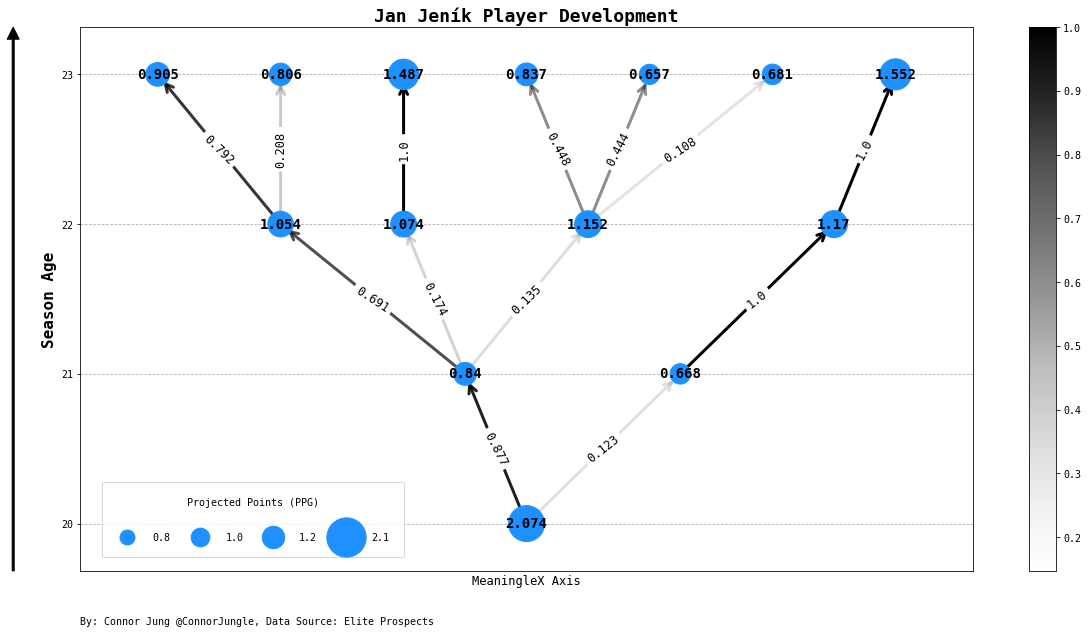

In [116]:
matplotlib.rc('font',family='monospace')

fig, ax = plt.subplots(figsize=(20,10))

# create tree layout and rescale based on age
pos = graphviz_layout(player.G, prog='dot')
# array of ages for y-axis
ages = np.arange(player.start_age,
                 player.projections.season_age.astype(int).max() + 1,
                 1)
# rescale x,y coordinates
y = np.array([xy[1] for _, xy in pos.items()])
y_rescale = (y.max() / y.min()) / (ages.max() / ages.min())
y_map = { k:v for k,v in zip(sorted(np.unique(y))[::-1], ages)}
pos = {u :(v[0] / y_rescale, y_map[v[1]]) for u,v in pos.items()}

node_sizes = [player.G.nodes[g]['ppg'] / player.position_ppg[player.position] * 300 for g in player.G.nodes]
player.node_sizes = node_sizes

# draw nodes
nodes = nx.draw_networkx_nodes(player.G,
                               pos,
                               node_size=node_sizes,
                               node_color='dodgerblue',
                               ax=ax)
node_labels = nx.get_node_attributes(player.G, 'ppg')
nx.draw_networkx_labels(player.G,
                        pos,
                        node_labels,
                        font_size=14,
                        ax=ax, 
                        font_family='monospace', 
                        font_color='black', 
                        font_weight='bold',
                        font_stretch = 'semi-expanded')

# draw edges
edges = nx.draw_networkx_edges(player.G,
                               pos, 
                               arrowstyle='->', 
                               arrowsize=20, 
                               edge_cmap=plt.cm.Greys, 
                               width=3,
                               ax=ax)
edge_labels = nx.get_edge_attributes(player.G, 'probability')
nx.draw_networkx_edge_labels(player.G, 
                             pos, 
                             edge_labels, 
                             font_size=12,
                             ax=ax, 
                             font_family='monospace')

# set alpha value for each edge
for i in range(len(player.projections)):
    edges[i].set_alpha(player.projections.probability.values[i])

# colourscale for colourbar
pc = matplotlib.collections.PatchCollection(edges, cmap=plt.cm.Greys)
pc.set_array([(5 + i) / (30 + 4) for i in range(30)])
plt.colorbar(pc)
# create legend for projected points
custom_leg = [mlines.Line2D([0], [0], marker='o', color='dodgerblue', linestyle='None') for _ in range(0,5)]
# 4 part distirubtion
Q1 = np.percentile([player.G.nodes[g]['ppg'] for g in player.G.nodes], 25, interpolation = 'midpoint').round(1) 
Q2 = np.percentile([player.G.nodes[g]['ppg'] for g in player.G.nodes], 50, interpolation = 'midpoint').round(1) 
Q3 = np.percentile([player.G.nodes[g]['ppg'] for g in player.G.nodes], 75, interpolation = 'midpoint').round(1)
Q4 = np.percentile([player.G.nodes[g]['ppg'] for g in player.G.nodes], 100, interpolation = 'midpoint').round(1)
point_range=[Q1, Q2, Q3, Q4]
player.point_range = point_range
custom_leg = [mlines.Line2D([0], [0],
                            marker='o',
                            color='dodgerblue',
                            markersize=point_range[i] / player.position_ppg[player.position] * 9 ,
                            linestyle='None') for i in range(0,4)]
leg = plt.legend(custom_leg, point_range,
                 title = 'Projected Points (PPG)',
#                  markerscale=30,
                 labelspacing=2.5,
                 handletextpad=1.5,
                 borderpad=1.5,
                 ncol=4,
                 loc=(0.025, .025))

ax.annotate('', xytext=(-.075, 0),  xy=(-.075, 1),  xycoords='axes fraction', arrowprops=dict(color='black', width=2))

# axis changes
ax.set_yticks(ages)
ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)
ax.set_ylabel('Season Age', size=16, weight='bold')
ax.set_xlabel('MeaningleX Axis', size=12)
plt.gca().yaxis.grid(True, linestyle='--',)
plt.title(f"{player.player_name} Player Development", fontsize=18, fontweight='bold')
footnote = """By: Connor Jung @ConnorJungle, Data Source: Elite Prospects"""
plt.figtext(0.125, 0.05, footnote)

In [117]:
edge_labels

{(1, 2): 0.877,
 (1, 3): 0.123,
 (2, 4): 0.691,
 (2, 5): 0.174,
 (2, 6): 0.135,
 (3, 7): 1.0,
 (4, 8): 0.792,
 (4, 9): 0.208,
 (5, 10): 1.0,
 (6, 11): 0.448,
 (6, 12): 0.444,
 (6, 13): 0.108,
 (7, 14): 1.0}

In [220]:
player.projections[['season_age', 'league', 'ppg']]

,season_age,league,ppg
0,21.0,AHL,0.840226
1,21.0,NHL,0.668343
0,22.0,AHL,1.054404
1,22.0,NHL,1.073548
2,22.0,NCAA,1.152411
0,22.0,NHL,1.169795
0,23.0,AHL,0.904883
1,23.0,NHL,0.806052
0,23.0,NHL,1.487392
0,23.0,NCAA,0.836525


In [94]:
def nhl_expected_value(G, node):
    
    value = []
    for n in nx.descendants(G, node):
        value.append(G.nodes[n]['xvalue'] if G.nodes[n]['league'] == 'NHL' else 0)
    return np.sum(value)

for i, n in enumerate(player.G.nodes):
    print(i+1, nhl_expected_value(player.G, n))

1 262.423
2 150.92999999999998
3 98.011
4 33.326
5 74.447
6 2.857
7 62.615
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0


In [99]:
62.615 + 2.857  + 33.326

98.798

In [42]:
def node_probability(G, node):
    
    probabilities = []
    for n in sorted(nx.ancestors(G, node))[::-1]:
        probabilities.append(G.edges[(n, node)]['probability'])
        node=n
    return np.prod(probabilities)

def node_expected_value(G, node):

    return sum(G.nodes[node]['epoints'] * G.nodes[node]['cond_prob'] for n in nx.ancestors(G, node) | {node})

def nhl_expected_value(G, node):
    
    value = []
    for n in sorted(nx.descendants(G, node)):
        value.append(G.nodes[n]['xvalue'] if G.nodes[n]['league'] == 'NHL' else 0)
    return np.sum(value)

def nhl_expected_value(G, node):
        
    return np.sum([G.nodes[n]['xvalue'] for n in nx.descendants(G, node) if G.nodes[n]['league'] == 'NHL']).round(1)

In [137]:
df = df.assign(nhl_xvalue=np.nan,xvalue=np.nan,cond_probability=np.nan,)
for node in df.node:
    df.loc[df.node == node, ['nhl_xvalue']] = node_expected_value(G, node)
    df.loc[df.node == node, ['xvalue']] = nhl_expected_value(G, node)
    df.loc[df.node == node, ['cond_probability']] = node_probability(G, node)

Node 2 xV: 124.17275200000002
Node 3 xV: 15.551628000000001
Node 4 xV: 42.511720020000006
Node 5 xV: 74.86334856000002
Node 6 xV: 32.917013999999995
Node 7 xV: 58.35763208
Node 8 xV: 14.75639497332
Node 9 xV: 48.53716051184
Node 10 xV: 33.473712000000006


### Linear Model for Team Percentage of Scoring

In [422]:
df = pd.read_csv('player_season_stats.csv')
X, y, _ = prepare_features(df, 'ppg_y_plus_1')

In [477]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.style as style

def fit_team_scoring_model(data, scoring_metric):
    
    df = get_next_season_data(data)

    df = df[(df.gp < 85)
        & (df.season_age >= 17)
        & (df.season_age <= 23)
        & (df.gp_y_plus_1.notnull())]
    
    age = pd.DataFrame(df.season_age)
    
    df = df.set_index(['playerid', 'player', 'season_age'])
    
    age.index = df.index
    
    features = df[[scoring_metric]].merge(
        pd.get_dummies(df['league'], drop_first=True),
        left_index=True,
        right_index=True).merge(
        pd.get_dummies(age.season_age, drop_first=True),
        left_index=True,
        right_index=True)
    
    label = 'perc_team_tp' if scoring_metric == 'ppg' \
    else 'perc_team_g' if scoring_metric == 'gpg'\
    else 'perc_team_a' 
    
    target = df[label]

    lin_model = LinearRegression()

    lin_model.fit(features[target.notnull().values], target[target.notnull().values])

    print('Mean Absolute Error: ', mean_absolute_error(target[target.notnull().values],
                                                       lin_model.predict(features[target.notnull().values])))

    print('Mean Squared Error: ', mean_squared_error(target[target.notnull().values],
                                                       lin_model.predict(features[target.notnull().values])))

    sns.distplot(target[target.notnull().values])
    plt.show()

    plt.rc('axes', facecolor='#ffffff', edgecolor='#ffffff',
           axisbelow=True, grid=True,
          )
    plt.rc('grid', color='grey', linestyle='dashed')
    plt.rc('patch', edgecolor='#ffffff', facecolor='#ffffff')

    plt.figure(figsize=(10,5),facecolor="#ffffff")

    slope, intercept, r_value, p_value, std_err = stats.linregress(lin_model.predict(features[target.notnull().values]),
                                                                   target[target.notnull().values])

    sns.regplot(x = lin_model.predict(features[target.notnull().values]),
                y = target[target.notnull().values],
                line_kws={'label':"y={0:.1f}x+{1:.1f}, p-value: {2:2f}, R^2: {3:2f}".format(slope,
                                                                                               intercept,
                                                                                               p_value, 
                                                                                               r_value ** 2)})
    plt.title('Predicting Percentage of Team TP [Full LR]')
    plt.legend()
    plt.show()
    
    joblib.dump(lin_model, f'{scoring_metric}_team_model.pkl')
    
    return features

Mean Absolute Error:  0.008165198328830106
Mean Squared Error:  0.0001425965256690886


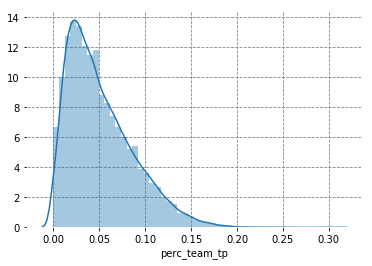

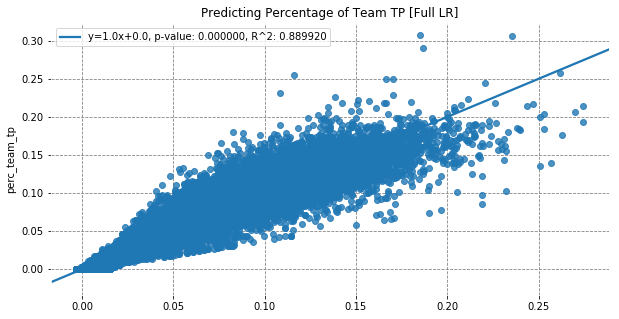

Mean Absolute Error:  0.00850062843903706
Mean Squared Error:  0.0001545322927969362


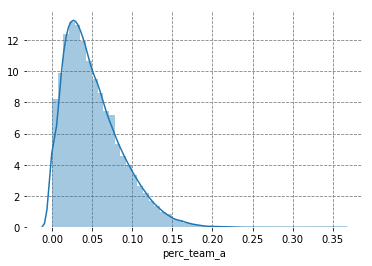

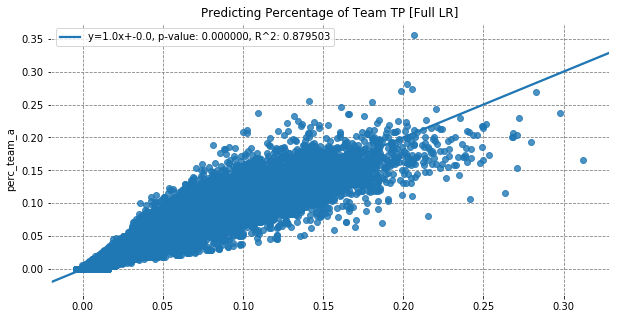

Mean Absolute Error:  0.008348387621897654
Mean Squared Error:  0.00016889321315668453


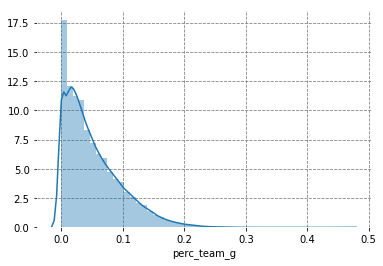

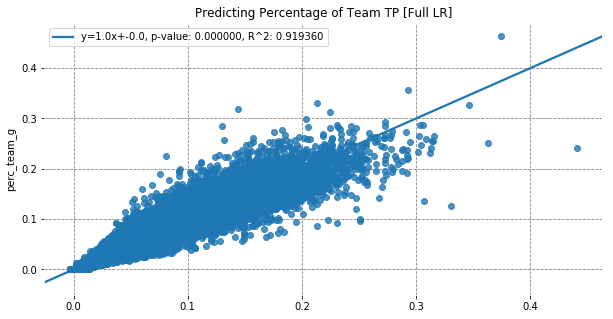

In [478]:
metric = ['ppg', 'apg', 'gpg']
for met in metric:
    feats = fit_team_scoring_model(df, met)

In [223]:
nx.readwrite.json_graph.node_link_data(G)

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'league': 'SHL', 'id': 1},
  {'league': 'SHL',
   'age': 21.0,
   'epoints': 23.43,
   'cond_prob': 0.783,
   'xvalue': 36.691,
   'id': 2},
  {'league': 'AHL',
   'age': 21.0,
   'epoints': 42.160000000000004,
   'cond_prob': 0.208,
   'xvalue': 17.539,
   'id': 3},
  {'league': 'NHL',
   'age': 21.0,
   'epoints': 28.208,
   'cond_prob': 0.01,
   'xvalue': 0.564,
   'id': 4},
  {'league': 'SHL',
   'age': 22.0,
   'epoints': 41.14,
   'cond_prob': 0.42595200000000005,
   'xvalue': 52.571,
   'id': 5},
  {'league': 'AHL',
   'age': 22.0,
   'epoints': 56.08,
   'cond_prob': 0.317898,
   'xvalue': 53.483,
   'id': 6},
  {'league': 'NHL',
   'age': 22.0,
   'epoints': 37.72,
   'cond_prob': 0.039150000000000004,
   'xvalue': 4.43,
   'id': 7},
  {'league': 'AHL',
   'age': 22.0,
   'epoints': 68.64,
   'cond_prob': 0.178672,
   'xvalue': 36.792,
   'id': 8},
  {'league': 'NHL',
   'age': 22.0,
   'epoints': 44.362,
   'c

In [236]:
def get_primary_position(val):

    match = re.search('[c,w,lw,rw,f]', val.lower())

    if match:
        return 'F'
    else:
        return 'D'

In [237]:
data = player.dataset
data['primary_position'] = data.position.apply(get_primary_position)

In [243]:
def scoring_by_position(self):
    
    data = player.dataset
    
    data['primary_position'] = data.position.apply(get_primary_position)
    
    self.position_ppg = data[(data.season_age >= 17)
                             & (data.season_age <= 23)].groupby('primary_position').ppg.mean().to_dict()



'F'